In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -r '/content/gdrive/MyDrive/cmpt420hw3/requirments.txt'

In [3]:
import os
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from tqdm import tqdm
import numpy as np
import random
import glob
from sklearn.model_selection import train_test_split

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [6]:
class LanguageModelDataset(Dataset):
    def __init__(self, file_path):
        self.chunk_length = 13
        self.seqs = self._read_lines(file_path)
        self.vocab = self._build_vocab()

    def _read_lines(self, file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            document = file.read()
        tokens = word_tokenize(document)
        grouped_tokens = [tokens[i:i + self.chunk_length] for i in range(0, len(tokens) - self.chunk_length + 1)]
        return grouped_tokens


    def _build_vocab(self):
        all_tokens = [token for group in self.seqs for token in group]
        vocab = {token: idx for idx, token in enumerate(sorted(set(all_tokens)))}
        return vocab

    def _seq_to_tensor(self, seq):
        token_ids = [self.vocab[token] for token in seq]
        return torch.tensor(token_ids, dtype=torch.long)

    def reverse_token_ids(self, token_ids):
        return [token for idx, token in sorted([(idx, token) for token, idx in self.vocab.items()
                                                if idx in token_ids], key=lambda x: token_ids.index(x[0]))]

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        seq = self.seqs[idx]
        input_tensor = self._seq_to_tensor(seq)
        # input and target
        return input_tensor[:-1], input_tensor[1:]

In [7]:
class ClassifierModelDataset(Dataset):
    def __init__(self, data_path):
        self.news, self.groups = self.data_loader(data_path)
        self.max_seq_length = 180
        self.seqs = self._read_news()
        self.vocab = self._build_vocab()
        # self.labels = {label: idx for idx, label in enumerate(set(self.group))}
        # self.seqs_totensor = self._seqs_to_tensor()
        # self.groups_totensor = torch.tensor(self.groups)
    def _read_news(self):
        tokenized_news = []
        for article in self.news:
            tokens = word_tokenize(article)[:self.max_seq_length]
            # Pad or truncate the tokens
            if len(tokens) < self.max_seq_length:
                tokens += ['<PAD>'] * (self.max_seq_length - len(tokens))
            tokenized_news.append(tokens)
        return tokenized_news

    def _build_vocab(self):
        all_tokens = [token for group in self.seqs for token in group]
        vocab = {token: idx for idx, token in enumerate(sorted(set(all_tokens)))}
        return vocab

    def _seq_to_tensor(self, seq):
        token_ids = [self.vocab[token] for token in seq]
        return torch.tensor(token_ids, dtype=torch.long)
    def _seqs_to_tensor(self):
        tensor_data = [[torch.tensor(item) for item in sublist] for sublist in self.seqs]
        return torch.tensor(tensor_data)
    def _label_to_tensor(self, group):
        return torch.tensor(group, dtype=torch.long)

    def to_categories(self, name, cat=["politics", "rec", "comp", "religion"]):
        for i in range(len(cat)):
            if str.find(name, cat[i]) > -1:
                return (i)
        print("Unexpected folder: " + name)  # print the folder name which does not include expected categories
        return ("wth")

    def data_loader(self, data_path):
        categories = os.listdir(data_path)
        news = []  # news content
        groups = []  # category which it belong to

        for cat in categories:
            # print("Category:" + cat)
            for the_new_path in glob.glob(data_path + '/' + cat + '/*'):
                news.append(open(the_new_path, encoding="ISO-8859-1", mode='r').read())
                groups.append(cat)
        return news, list(map(self.to_categories, groups))

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        new = self.seqs[idx]
        group = self.groups[idx]
        # Encode news and label
        encoded_news = self._seq_to_tensor(new)
        encoded_label = self._label_to_tensor(group)
        return encoded_news, encoded_label



In [8]:
def generate_sentences(model, vocab, num_sentences=10, sentence_length=15, device="cpu"):
    model.eval()

    sentences = []

    with torch.no_grad():
        for _ in range(num_sentences):
            # Initialize hidden state
            hidden = None

            # Initialize the first input token
            random_token_id = random.choice(list(vocab.values()))
            input_token = torch.tensor([random_token_id], dtype=torch.long).unsqueeze(0).to(device)

            sentence = [word for word, idx in vocab.items() if idx == random_token_id]

            for _ in range(sentence_length):
                output, hidden = model(input_token, hidden)
                probabilities = F.softmax(output.squeeze(0), dim=-1)

                # Sample a word from the output distribution
                sampled_word_id = torch.multinomial(probabilities, 1).item()

                # Convert the sampled word ID to the actual word
                sampled_word = [word for word, idx in vocab.items() if idx == sampled_word_id][0]

                # Append the sampled word to the sentence
                sentence.append(sampled_word)

                # Prepare the next input token
                input_token = torch.tensor([sampled_word_id], dtype=torch.long).unsqueeze(0).to(device)

            sentences.append(sentence)

    return sentences


In [9]:
def compute_accuracy(model, data_loader, device):

    model.eval()
    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (inputs, targets) in enumerate(data_loader):

            inputs = inputs.to(device)
            targets = targets.float().to(device)

            outputs, _ = model(inputs)
            # print(outputs.shape)
            # os.abort()
            _, predicted_labels = torch.max(outputs, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum().item()
    return float(correct_pred/num_examples) * 100


**Question1:** Implement simple Elman network

In [10]:
class ElmanRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(ElmanRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):

        # print("input size before embedding: ", x.shape) torch.Size([batchSize, 1])
        embedded = self.embedding(x)
        # print("input size after embedding: ", embedded.shape) torch.Size([batchSize, 1, 64])
        output, new_hidden = self.rnn(embedded, hidden)
        logits = self.fc(output)
        return logits, new_hidden

**Question1:** Train the Elman network with TBTT

In [15]:
def train_tbtt(dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Instantiate the Elman RNN model
    vocab_size = len(dataset.vocab)
    embedding_dim = 30
    hidden_dim = 500
    elman_model = ElmanRNN(vocab_size, embedding_dim, hidden_dim)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(elman_model.parameters(), lr=0.001)

    # Create DataLoader for the dataset
    batch_size = 128
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    avg_loss = []

    elman_model = elman_model.to(device)

    # Training loop
    num_epochs = 5
    for epoch in range(num_epochs):
        elman_model.train()
        total_loss = 0.0
        for i, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            hidden = None
            # for t in every time step of the sequence
            for t in range(inputs.size(1)):
                # every time update hidden stat in sequential
                outputs, hidden = elman_model(inputs[:, t].unsqueeze(1),
                                              hidden.detach() if hidden is not None else hidden)

                # print("the size of input sequence load from dataset: ", inputs.shape)
                # print("the size of output: ", outputs.shape)
                # if t == 3: os.abort()

                # Flatten the outputs and targets for the loss calculation
                loss = criterion(outputs.view(-1, vocab_size), targets[:, t].view(-1))
                loss.backward(retain_graph=True)  # Retain graph for truncated BPTT
                optimizer.step()
                total_loss += loss.item()
            total_loss += total_loss / inputs.size(1)


        average_loss = total_loss / len(dataloader)
        avg_loss.append(average_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")
    # Save the trained model
    if os.path.isfile("/content/gdrive/MyDrive/cmpt420hw3/model/"):
      print("overwrite the elman_model_tbtt.pth")
    torch.save(elman_model.state_dict(), "/content/gdrive/MyDrive/cmpt420hw3/model/elman_model_tbtt.pth")
    return avg_loss

In [ ]:
# file_path = './data/English Literature.txt'
file_path = '/content/gdrive/MyDrive/cmpt420hw3/data/English Literature.txt'
custom_dataset = LanguageModelDataset(file_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
losses = train_tbtt(custom_dataset)
# Plot the loss curve
plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

100%|██████████| 1989/1989 [1:23:45<00:00,  2.53s/it]


Epoch 1/5, Loss: 71.11304075098205


 38%|███▊      | 750/1989 [31:23<50:38,  2.45s/it]

**Question2:** Train the Elman network with BTT

In [ ]:
def train_btt(dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Instantiate the Elman RNN model
    vocab_size = len(dataset.vocab)
    embedding_dim = 64
    hidden_dim = 500
    elman_model = ElmanRNN(vocab_size, embedding_dim, hidden_dim)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(elman_model.parameters(), lr=0.001)

    # Create DataLoader for the dataset
    batch_size = 32
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    avg_loss = []

    elman_model = elman_model.to(device)
    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        elman_model.train()
        total_loss = 0.0

        for i, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):

            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            outputs, _ = elman_model(inputs)
            # print("vocab size: ", vocab_size)
            # print("the size of input sequence load from dataset: ", inputs.shape)
            # print("the size of output: ", outputs.shape)
            # os.abort()
            # Flatten the outputs (do the softmax) and targets for the loss calculation
            loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(dataloader)
        avg_loss.append(average_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")

    # Save the trained model
    torch.save(elman_model.state_dict(), "/content/gdrive/MyDrive/cmpt420hw3/model/elman_model_btt.pth")
    return avg_loss


100%|██████████| 7954/7954 [01:13<00:00, 107.71it/s]


Epoch 1/10, Loss: 4.256729125676816


100%|██████████| 7954/7954 [01:13<00:00, 108.13it/s]


Epoch 2/10, Loss: 2.9131670137551193


100%|██████████| 7954/7954 [01:13<00:00, 108.18it/s]


Epoch 3/10, Loss: 2.475552731433165


100%|██████████| 7954/7954 [01:13<00:00, 108.25it/s]


Epoch 4/10, Loss: 2.2260150644897307


100%|██████████| 7954/7954 [01:13<00:00, 108.22it/s]


Epoch 5/10, Loss: 2.0615118077000933


100%|██████████| 7954/7954 [01:13<00:00, 108.29it/s]


Epoch 6/10, Loss: 1.947177416660212


100%|██████████| 7954/7954 [01:13<00:00, 108.29it/s]


Epoch 7/10, Loss: 1.8612628297827367


100%|██████████| 7954/7954 [01:13<00:00, 108.16it/s]


Epoch 8/10, Loss: 1.796327767380824


100%|██████████| 7954/7954 [01:13<00:00, 108.31it/s]


Epoch 9/10, Loss: 1.7439064502656114


100%|██████████| 7954/7954 [01:13<00:00, 108.30it/s]


Epoch 10/10, Loss: 1.7012591774900685


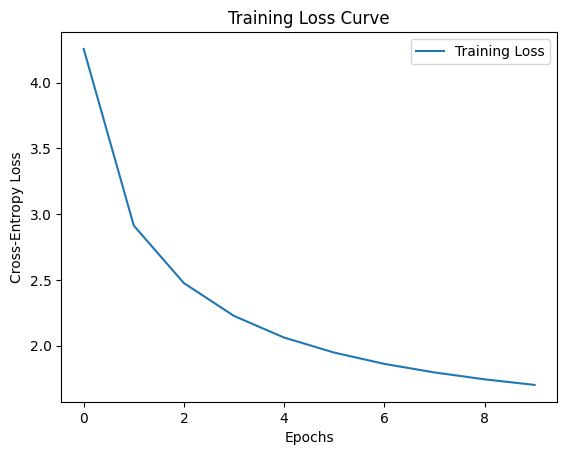

In [ ]:
# file_path = './data/English Literature.txt'
file_path = '/content/gdrive/MyDrive/cmpt420hw3/data/English Literature.txt'
custom_dataset = LanguageModelDataset(file_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
losses = train_btt(custom_dataset)
# Plot the loss curve
plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

**Question3(a):**  Improve the Elman network with GRU that was trained with BTT

In [ ]:
class ElmanGRURNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(ElmanGRURNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        output, new_hidden = self.rnn(embedded, hidden)
        logits = self.fc(output)
        return logits, new_hidden


In [ ]:
def trainGRU_btt(dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Instantiate the Elman RNN model
    vocab_size = len(dataset.vocab)
    embedding_dim = 64
    hidden_dim = 500
    elman_model = ElmanGRURNN(vocab_size, embedding_dim, hidden_dim)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(elman_model.parameters(), lr=0.001)

    # Create DataLoader for the dataset
    batch_size = 16
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    avg_loss = []

    elman_model = elman_model.to(device)
    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        elman_model.train()
        total_loss = 0.0

        for i, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):

            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            outputs, _ = elman_model(inputs)
            # print("vocab size: ", vocab_size)
            # print("the size of input sequence load from dataset: ", inputs.shape)
            # print("the size of output: ", outputs.shape)
            # os.abort()
            # Flatten the outputs (do the softmax) and targets for the loss calculation
            loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(dataloader)
        avg_loss.append(average_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")

    # Save the trained model
    torch.save(elman_model.state_dict(), "/content/gdrive/MyDrive/cmpt420hw3/model/elmanGRU_model_btt.pth")
    return avg_loss


100%|██████████| 19577/19577 [00:59<00:00, 326.66it/s]


Epoch 1/10, Loss: 3.588424397822864


100%|██████████| 19577/19577 [00:58<00:00, 331.88it/s]


Epoch 2/10, Loss: 2.1546417547756835


100%|██████████| 19577/19577 [00:58<00:00, 333.80it/s]


Epoch 3/10, Loss: 1.833359765776296


100%|██████████| 19577/19577 [00:58<00:00, 332.89it/s]


Epoch 4/10, Loss: 1.6830306012180953


100%|██████████| 19577/19577 [00:58<00:00, 332.56it/s]


Epoch 5/10, Loss: 1.5982826692173733


100%|██████████| 19577/19577 [00:58<00:00, 331.84it/s]


Epoch 6/10, Loss: 1.5453824876807296


100%|██████████| 19577/19577 [00:58<00:00, 332.23it/s]


Epoch 7/10, Loss: 1.5122611404756192


100%|██████████| 19577/19577 [00:59<00:00, 329.45it/s]


Epoch 8/10, Loss: 1.490833740257636


100%|██████████| 19577/19577 [00:59<00:00, 329.41it/s]


Epoch 9/10, Loss: 1.4829449390387117


100%|██████████| 19577/19577 [00:58<00:00, 333.27it/s]


Epoch 10/10, Loss: 1.4817460688420845


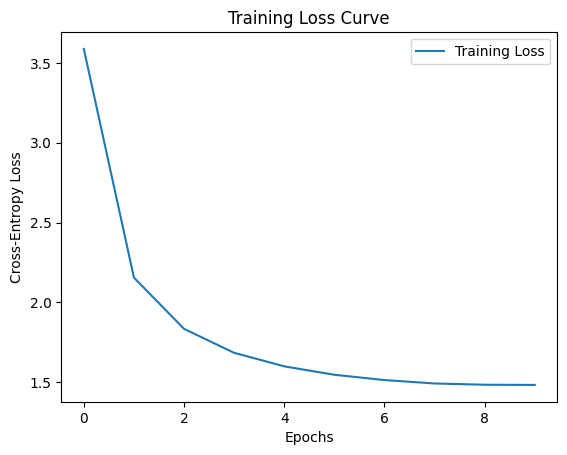

In [ ]:
# file_path = './data/English Literature.txt'
file_path = '/content/gdrive/MyDrive/cmpt420hw3/data/English Literature.txt'
custom_dataset = LanguageModelDataset(file_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
losses = trainGRU_btt(custom_dataset)
# Plot the loss curve
plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

**Question3(b):  Text generation from given language model**

In [ ]:
file_path = '/content/gdrive/MyDrive/cmpt420hw3/data/English Literature.txt'

Text Generated from model in part 1 (Elman model train with TBTT)

In [ ]:
custom_dataset = LanguageModelDataset(file_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train = True
# decide to generate OR to train
generate = True
if generate:
        train = False
        vocab_size = len(custom_dataset.vocab)
        embedding_dim = 64
        hidden_dim = 500
        model = ElmanRNN(vocab_size, embedding_dim, hidden_dim)
        model = model.to(device)
        state_dict = torch.load("/content/gdrive/MyDrive/cmpt420hw3/model/elman_model_tbtt.pth", map_location=torch.device('cpu'))
        model.load_state_dict(state_dict)
        # Generate synthetic sentences
        generated_sentences = generate_sentences(model, custom_dataset.vocab, num_sentences=10, sentence_length=15, device="cpu")
        # Print the generated sentences
        for i, sentence in enumerate(generated_sentences, start=1):
            print(f"Sentence {i}: {' '.join(sentence)}")

RuntimeError: Error(s) in loading state_dict for ElmanRNN:
	size mismatch for embedding.weight: copying a param with shape torch.Size([14310, 100]) from checkpoint, the shape in current model is torch.Size([14310, 64]).
	size mismatch for rnn.weight_ih_l0: copying a param with shape torch.Size([500, 100]) from checkpoint, the shape in current model is torch.Size([500, 64]).

Text Generated from model in part 1 (Elman model train with BTT)

In [ ]:
custom_dataset = LanguageModelDataset(file_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train = True
# decide to generate OR to train
generate = True
if generate:
        train = False
        vocab_size = len(custom_dataset.vocab)
        embedding_dim = 64
        hidden_dim = 500
        # model =ElmanGRURNN(vocab_size, embedding_dim, hidden_dim)
        model = ElmanRNN(vocab_size, embedding_dim, hidden_dim)
        model = model.to(device)
        state_dict = torch.load("/content/gdrive/MyDrive/cmpt420hw3/model/elman_model_btt.pth", map_location=torch.device('cpu'))
        model.load_state_dict(state_dict)
        # Generate synthetic sentences
        generated_sentences = generate_sentences(model, custom_dataset.vocab, num_sentences=10, sentence_length=15, device="cpu")
        # Print the generated sentences
        for i, sentence in enumerate(generated_sentences, start=1):
            print(f"Sentence {i}: {' '.join(sentence)}")


Sentence 1: ram , Warwick , do but bid from kill to say , he hath not used
Sentence 2: Tyrian tapestry ; In ivory coffers I take my leave , and thank heaven yields the
Sentence 3: toe The bitter mark nor honesty nor name : I crave the place else may I
Sentence 4: est Sigeia tellus , ' I trust you , my lord . First Murderer : Ho
Sentence 5: beguil 'd , whom they have all shadow will for her . PETRUCHIO : And ,
Sentence 6: Open Thy gate of mercy , gracious lord ; he comes not ask me thus .
Sentence 7: threefold distress 'd , Pour all , And , by a horseman , and a bold
Sentence 8: sciences ? Theretake it to this ; I 'll be as my false one , she
Sentence 9: wagoner a noble memory , and many children of the our kiss their griefs ! Thou
Sentence 10: buildeth in our aery 's nest . O God , that seest it , do not


Text Generated from model in part 3 (Elman model with GRU and train on BTT)

In [ ]:
generate = True
if generate:
        train = False
        vocab_size = len(custom_dataset.vocab)
        embedding_dim = 64
        hidden_dim = 500
        # model =ElmanGRURNN(vocab_size, embedding_dim, hidden_dim)
        model = ElmanGRURNN(vocab_size, embedding_dim, hidden_dim)
        model = model.to(device)
        state_dict = torch.load("/content/gdrive/MyDrive/cmpt420hw3/model/elmanGRU_model_btt.pth", map_location=torch.device('cpu'))
        model.load_state_dict(state_dict)
        # Generate synthetic sentences
        generated_sentences = generate_sentences(model, custom_dataset.vocab, num_sentences=10, sentence_length=15, device="cpu")
        # Print the generated sentences
        for i, sentence in enumerate(generated_sentences, start=1):
            print(f"Sentence {i}: {' '.join(sentence)}")

Sentence 1: massacre ! I tell thee more : And in his needy shop a tortoise hung ,
Sentence 2: paced along Upon the giddy footing of our hatches , Methought we proclaim 'd a bloody
Sentence 3: infect my son Aumerle . And am I king 'd , and this is made A
Sentence 4: exclaims : My Lord of York that I at the first which I think , that
Sentence 5: City vain but I thought in their own . SICINIUS : Have himself a time had
Sentence 6: fostered ; And , on my life , Did perish with the infant . 'T is
Sentence 7: Frenchwoman . NORTHUMBERLAND : Beshrew them , the three lords torments my heart : I do
Sentence 8: pilot ? DUKE VINCENTIO : My best Camillo , to thy slaughter 'd this , Thou
Sentence 9: blaze in Shall ; for the very hour it were damnable , I mean : but
Sentence 10: Gallia away . Keep the house , sir ? AUTOLYCUS : Whether I make of mind


**Question4:  Implement a text classification model**

In [ ]:
class MyClassifer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes=4):
        super(MyClassifer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):

        embedded = self.embedding(x)
        output, new_hidden = self.rnn(embedded)
        new_hidden.squeeze_(0)
        logits = self.fc(new_hidden)
        return logits, new_hidden


In [ ]:
def train_MyClassifier(dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Instantiate the Elman RNN model
    vocab_size = len(dataset.vocab)
    embedding_dim = 64
    hidden_dim = 500
    classifer = MyClassifer(vocab_size, embedding_dim, hidden_dim)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifer.parameters(), lr=0.001)

    # Create DataLoader for the dataset
    batch_size = 64
    # Split the indices into training and validation
    train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.1, random_state=42)
    # X_train, X_val, y_train, y_val = train_test_split(dataset.seqs_totensor, dataset.groups_totensor, test_size=0.1, random_state=42)
    # Create Subset datasets for training and validation
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    # Create DataLoader instances for training and validation
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    avg_loss = []
    accuaries = []
    classifer = classifer.to(device)
    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        classifer.train()
        total_loss = 0.0

        for i, (inputs, targets) in tqdm(enumerate(train_loader), total=len(train_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            outputs, _ = classifer(inputs)
            # print("vocab size: ", vocab_size)
            # print("the size of input sequence load from dataset: ", inputs.shape)
            # print("the size of output: ", outputs.shape)
            # print("the size of target: ", targets.shape)
            # os.abort()
            # Flatten the outputs (do the softmax) and targets for the loss calculation
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            ### LOGGING
            if not i % 50:
                print(f'Epoch: {epoch + 1:03d}/{num_epochs:03d} | '
                      f'Batch {i:03d}/{len(train_loader):03d} | '
                      f'Loss: {loss:.4f}')

            total_loss += loss.item()

        # END OF THE LOOP
        with torch.set_grad_enabled(False):
            print(f'training accuracy: '
                  f'{compute_accuracy(classifer, train_loader, device):.2f}%'
                  f'\nvalid accuracy: '
                  f'{compute_accuracy(classifer, val_loader, device):.2f}%')
            acc = compute_accuracy(classifer, val_loader, device)
            accuaries.append(acc)

        average_loss = total_loss / len(train_loader)
        avg_loss.append(average_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")

    # Save the trained model
    torch.save(classifer.state_dict(), "/content/gdrive/MyDrive/cmpt420hw3/model/classifer_model.pth")
    return accuaries


  2%|▏         | 3/185 [00:01<00:54,  3.35it/s]

Epoch: 001/010 | Batch 000/185 | Loss: 1.3922


 30%|██▉       | 55/185 [00:02<00:04, 30.91it/s]

Epoch: 001/010 | Batch 050/185 | Loss: 1.2490


 58%|█████▊    | 107/185 [00:04<00:02, 31.04it/s]

Epoch: 001/010 | Batch 100/185 | Loss: 1.3102


 84%|████████▍ | 155/185 [00:06<00:00, 30.71it/s]

Epoch: 001/010 | Batch 150/185 | Loss: 1.2239


100%|██████████| 185/185 [00:07<00:00, 26.29it/s]


training accuracy: 43.69%
valid accuracy: 41.50%
Epoch 1/10, Loss: 1.2825159317738302


  2%|▏         | 4/185 [00:00<00:05, 30.47it/s]

Epoch: 002/010 | Batch 000/185 | Loss: 1.2590


 30%|██▉       | 55/185 [00:01<00:04, 31.05it/s]

Epoch: 002/010 | Batch 050/185 | Loss: 1.2150


 58%|█████▊    | 107/185 [00:03<00:02, 30.49it/s]

Epoch: 002/010 | Batch 100/185 | Loss: 1.1282


 84%|████████▍ | 155/185 [00:05<00:00, 30.95it/s]

Epoch: 002/010 | Batch 150/185 | Loss: 1.0478


100%|██████████| 185/185 [00:06<00:00, 30.79it/s]


training accuracy: 66.66%
valid accuracy: 65.22%
Epoch 2/10, Loss: 1.1530685138058019


  2%|▏         | 4/185 [00:00<00:05, 31.38it/s]

Epoch: 003/010 | Batch 000/185 | Loss: 0.7876


 30%|███       | 56/185 [00:01<00:04, 30.18it/s]

Epoch: 003/010 | Batch 050/185 | Loss: 0.5391


 57%|█████▋    | 105/185 [00:03<00:02, 30.16it/s]

Epoch: 003/010 | Batch 100/185 | Loss: 0.6210


 84%|████████▍ | 155/185 [00:05<00:01, 29.75it/s]

Epoch: 003/010 | Batch 150/185 | Loss: 0.4583


100%|██████████| 185/185 [00:06<00:00, 30.14it/s]


training accuracy: 86.41%
valid accuracy: 83.37%
Epoch 3/10, Loss: 0.5946214228868485


  2%|▏         | 4/185 [00:00<00:05, 31.01it/s]

Epoch: 004/010 | Batch 000/185 | Loss: 0.2653


 30%|██▉       | 55/185 [00:01<00:04, 29.96it/s]

Epoch: 004/010 | Batch 050/185 | Loss: 0.2537


 58%|█████▊    | 107/185 [00:03<00:02, 30.26it/s]

Epoch: 004/010 | Batch 100/185 | Loss: 0.0942


 84%|████████▍ | 155/185 [00:05<00:00, 30.23it/s]

Epoch: 004/010 | Batch 150/185 | Loss: 0.2787


100%|██████████| 185/185 [00:06<00:00, 30.29it/s]


training accuracy: 95.57%
valid accuracy: 90.08%
Epoch 4/10, Loss: 0.22878919449206944


  2%|▏         | 4/185 [00:00<00:05, 30.30it/s]

Epoch: 005/010 | Batch 000/185 | Loss: 0.1333


 29%|██▉       | 54/185 [00:01<00:04, 29.71it/s]

Epoch: 005/010 | Batch 050/185 | Loss: 0.1165


 56%|█████▌    | 104/185 [00:03<00:02, 29.60it/s]

Epoch: 005/010 | Batch 100/185 | Loss: 0.0697


 83%|████████▎ | 154/185 [00:05<00:01, 29.56it/s]

Epoch: 005/010 | Batch 150/185 | Loss: 0.0777


100%|██████████| 185/185 [00:06<00:00, 29.78it/s]


training accuracy: 98.97%
valid accuracy: 92.91%
Epoch 5/10, Loss: 0.09853838408315505


  2%|▏         | 4/185 [00:00<00:05, 30.27it/s]

Epoch: 006/010 | Batch 000/185 | Loss: 0.0086


 30%|██▉       | 55/185 [00:01<00:04, 29.72it/s]

Epoch: 006/010 | Batch 050/185 | Loss: 0.0379


 57%|█████▋    | 106/185 [00:03<00:02, 29.56it/s]

Epoch: 006/010 | Batch 100/185 | Loss: 0.0240


 84%|████████▍ | 155/185 [00:05<00:01, 29.06it/s]

Epoch: 006/010 | Batch 150/185 | Loss: 0.0230


100%|██████████| 185/185 [00:06<00:00, 29.52it/s]


training accuracy: 99.55%
valid accuracy: 93.21%
Epoch 6/10, Loss: 0.04890800283315617


  2%|▏         | 4/185 [00:00<00:06, 29.84it/s]

Epoch: 007/010 | Batch 000/185 | Loss: 0.0106


 30%|██▉       | 55/185 [00:01<00:04, 29.41it/s]

Epoch: 007/010 | Batch 050/185 | Loss: 0.0198


 57%|█████▋    | 106/185 [00:03<00:02, 29.31it/s]

Epoch: 007/010 | Batch 100/185 | Loss: 0.0167


 84%|████████▍ | 155/185 [00:05<00:01, 29.19it/s]

Epoch: 007/010 | Batch 150/185 | Loss: 0.0017


100%|██████████| 185/185 [00:06<00:00, 29.39it/s]


training accuracy: 99.71%
valid accuracy: 93.14%
Epoch 7/10, Loss: 0.030485888631271853


  2%|▏         | 3/185 [00:00<00:06, 29.05it/s]

Epoch: 008/010 | Batch 000/185 | Loss: 0.0429


 29%|██▉       | 54/185 [00:01<00:04, 28.39it/s]

Epoch: 008/010 | Batch 050/185 | Loss: 0.0194


 57%|█████▋    | 105/185 [00:03<00:02, 28.99it/s]

Epoch: 008/010 | Batch 100/185 | Loss: 0.0156


 84%|████████▍ | 156/185 [00:05<00:01, 28.69it/s]

Epoch: 008/010 | Batch 150/185 | Loss: 0.0897


100%|██████████| 185/185 [00:06<00:00, 28.87it/s]


training accuracy: 99.80%
valid accuracy: 93.59%
Epoch 8/10, Loss: 0.025011905271408928


  2%|▏         | 3/185 [00:00<00:06, 29.87it/s]

Epoch: 009/010 | Batch 000/185 | Loss: 0.0022


 29%|██▉       | 54/185 [00:01<00:04, 28.93it/s]

Epoch: 009/010 | Batch 050/185 | Loss: 0.0229


 57%|█████▋    | 105/185 [00:03<00:02, 28.23it/s]

Epoch: 009/010 | Batch 100/185 | Loss: 0.0031


 84%|████████▍ | 156/185 [00:05<00:01, 28.14it/s]

Epoch: 009/010 | Batch 150/185 | Loss: 0.0021


100%|██████████| 185/185 [00:06<00:00, 28.59it/s]


training accuracy: 99.92%
valid accuracy: 93.36%
Epoch 9/10, Loss: 0.010454015734029707


  2%|▏         | 3/185 [00:00<00:06, 29.36it/s]

Epoch: 010/010 | Batch 000/185 | Loss: 0.0009


 29%|██▉       | 54/185 [00:01<00:04, 28.39it/s]

Epoch: 010/010 | Batch 050/185 | Loss: 0.0018


 57%|█████▋    | 105/185 [00:03<00:02, 28.33it/s]

Epoch: 010/010 | Batch 100/185 | Loss: 0.0052


 84%|████████▍ | 156/185 [00:05<00:01, 28.42it/s]

Epoch: 010/010 | Batch 150/185 | Loss: 0.0004


100%|██████████| 185/185 [00:06<00:00, 28.45it/s]


training accuracy: 99.36%
valid accuracy: 92.45%
Epoch 10/10, Loss: 0.004826977095925375


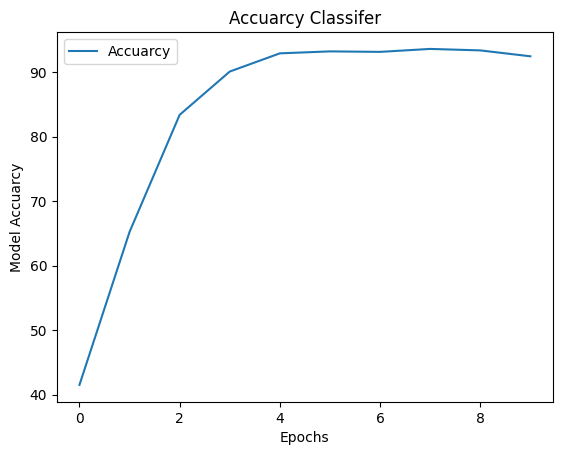

In [ ]:
data_pth = "/content/gdrive/MyDrive/cmpt420hw3/20news_subsampled"
# custom_dataset = LanguageModelDataset(file_path)
news = ClassifierModelDataset(data_pth)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
acc = train_MyClassifier(news)
plt.plot(acc, label='Accuarcy')
plt.xlabel('Epochs')
plt.ylabel('Model Accuarcy')
plt.title('Accuarcy Classifer')
plt.legend()
